<a href="https://colab.research.google.com/github/adolfoguimaraes/datascience/blob/main/code/09_laboratorio_clusterizacao2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluterização de Documentos Textuais

Nesse laboratório vamos aplicar técnicas de clusterização para agrupar documentos textuais. Como base de textos, vamos usar as sinopses dos TOP 250 filmes do site IMDB. As informações serão coletadas a partir da API [imdbpy](https://imdbpy.readthedocs.io/).

Vamos seguir as seguinte estratégia:

1. Instalação do pacote **imdbpy**;
2. Coletar as informações dos filmes utilizando a biblioteca;
3. Pré-processar os textos coletados para adequar ao formato aceito pelos algoritmos de clusterização;
4. Aplicar a clusterização avaliando o valor da métrica [Sillhoutte](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) e analisando o [Dendrograma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html);
5. Analisar os clusters  gerados a partir da análise dos centroídes.

Vamos começar :)

## 1. Instalação  do pacote `imdbpy`.

O pacote imdbpy permite coletar informações que são publicadas no site IMDb, um dos principais sites de cinema do mundo. Com a API é possível peagar informações sobre os filmes como título, ano, gênero, lista de atores, autores e demais informações. Veja a documentação para verificar as informações que podem ser coletadas.

In [1]:
# Instalação do pacote imdbpy
!pip install imdbpy

## 2. Coletar informações dos filmes utilizando a biblioteca `imdbpy`

Nessa etapa vamos coletar as informações dos top 250 filmes do IMDbPy e armazenar em um dataframe pandas. Para isso, vamos importar os pacotes necessários e executar a coleta das informações. 

In [3]:
# Imports necessários para essa etapa

from imdb import IMDb
import pandas as pd

In [4]:
# Coletar as referências as fiilmes

imdb = IMDb()
top250 = imdb.get_top250_movies()

In [5]:
# Coletar as informações textuais dos filmes e criar o dataframe

all_movies = {}
count = 0

for movie in top250:
  imdb.update(movie, info=['plot'])
  print("Movie %i - collecting %s" % (count, movie['title']))
  all_movies[count] = movie
  count += 1

Movie 0 - collecting The Shawshank Redemption
Movie 1 - collecting The Godfather
Movie 2 - collecting The Dark Knight
Movie 3 - collecting The Godfather Part II
Movie 4 - collecting 12 Angry Men
Movie 5 - collecting Schindler's List
Movie 6 - collecting The Lord of the Rings: The Return of the King
Movie 7 - collecting Pulp Fiction
Movie 8 - collecting The Lord of the Rings: The Fellowship of the Ring
Movie 9 - collecting The Good, the Bad and the Ugly
Movie 10 - collecting Forrest Gump
Movie 11 - collecting Fight Club
Movie 12 - collecting The Lord of the Rings: The Two Towers
Movie 13 - collecting Inception
Movie 14 - collecting Star Wars: Episode V - The Empire Strikes Back
Movie 15 - collecting The Matrix
Movie 16 - collecting Goodfellas
Movie 17 - collecting One Flew Over the Cuckoo's Nest
Movie 18 - collecting Se7en
Movie 19 - collecting Seven Samurai
Movie 20 - collecting It's a Wonderful Life
Movie 21 - collecting The Silence of the Lambs
Movie 22 - collecting City of God
Movie

In [6]:
# Os textos são coletados a partir da variável synopsis, que consiste na sinopse do filme e da variável plot 
# que são resumos escritos pelos usuários do site. Essas duas variáveis são concatenadas em um único texto
# que é associado ao filme. 

movie_database = []
count = 0

for m in all_movies:
  movie_instance = {}
  movie = all_movies[m]
  movie_instance['id'] = movie.movieID
  movie_instance['movie'] = movie['title']
  movie_instance['year'] = movie['year']

  text_ = ""

  if 'synopsis' in movie.keys():
    for synopsi in movie['synopsis']:
      text_ += synopsi + " "
    
  if 'plot' in movie.keys():
    for plot in movie['plot']:
      text_ += plot + " "

  movie_instance['text'] = text_

  if len(movie_instance) > 0:
    movie_database.append(movie_instance)



In [7]:
# Criando o Dataframe pandas

dataframe_movie =  pd.DataFrame(movie_database)
dataframe_movie

,id,movie,year,text
0,0111161,The Shawshank Redemption,1994,"In 1947, Andy Dufresne (\n\nTim Robbins\n\n), ..."
1,0068646,The Godfather,1972,"In late summer 1945, guests are gathered for t..."
2,0468569,The Dark Knight,2008,The movie begins with a gang of men with clown...
3,0071562,The Godfather Part II,1974,The Godfather Part II presents two parallel st...
4,0050083,12 Angry Men,1957,"In a New York City courthouse, an eighteen-yea..."
...,...,...,...,...
245,0071411,Dersu Uzala,1975,Dersu Uzala is named after the character playe...
246,0103639,Aladdin,1992,A street peddler (Robin Williams) is guiding t...
247,1454029,The Help,2011,"In civil-rights era Jackson, Mississippi, 23-y..."
248,0129167,The Iron Giant,1999,"In 1957, a large alien robot crashes from orbi..."


## 3. Pré-processar os textos coletados para adequar ao formato aceito pelos algoritmos de clusterização;

A terceira etapa consiste em pré-processa os textos de forma a gerar uma estrutura que possa ser utilizada como entrada dos algoritmos de clusterização. Essa estrutura é uma matriz na qual as linhas representam os textos e as colunas o vocabulário de toda coleção de textos. 

Isso pode ser feito por métodos de Vetorização. Vamos utilizar o `TfidfVectorizer` do scikit-learn. 

In [8]:
# Imports necessários
from sklearn.feature_extraction.text import TfidfVectorizer

# Criação da lista de textos que serão vetorizados. O método não aceita o dataframe como entrada. 
texts = list(dataframe_movie['text'])

# Aplicação da Vetorização
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3),
                                 max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)


In [9]:
tfidf_matrix.shape

(250, 100)

A variável `tfidf_matrix` representa a matriz que será entrada para os métodos de clusterização. Vamos aplica-lo na seção seguinte.

## 4. Aplicar a clusterização avaliando o valor da métrica `Sillhoutte` e analisando o `Dendrograma`

O primeiro passo é aplicar a clusterização utilizando o KMeans e avaliando a métrica Sillhoutte. Sobre esse métrica, vale destacar: 


    The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.


Um dos problemas do KMeans é que precisamos indicar o número de cluster que queremos formar. Quando isso não é possível de identificar, podemos usar uma análise inicial do valor da métrica para decidir qual valor utilizar para a separação. 

In [11]:
# Imports necessários
from sklearn.cluster import KMeans
from sklearn import metrics

# Variando o número de k de 1 a 10 para analisar os valores da métrica

for k in range(2, 10):
  km = KMeans(n_clusters=k,random_state=42)
  km.fit(tfidf_matrix)
  score = metrics.silhouette_score(tfidf_matrix, km.labels_, metric='euclidean')
  print("Para k=%i o valor Silhoutte foi de %.4f" % (k, score))


Para k=2 o valor Silhoutte foi de 0.0426
Para k=3 o valor Silhoutte foi de 0.0519
Para k=4 o valor Silhoutte foi de 0.0471
Para k=5 o valor Silhoutte foi de 0.0516
Para k=6 o valor Silhoutte foi de 0.0428
Para k=7 o valor Silhoutte foi de 0.0526
Para k=8 o valor Silhoutte foi de 0.0513
Para k=9 o valor Silhoutte foi de 0.0527


É fácil perceber que os valores estão muito próximos. Para simplificar a visualização, vamos escolher k = 3. Executando a clusterização, temos:


In [13]:
km = KMeans(n_clusters=5,random_state=42)
clusters_km = km.fit_predict(tfidf_matrix)

Vamos associar os clusters encontrados a uma coluna no dataframe.

In [14]:
dataframe_movie['cluster_km'] = clusters_km
dataframe_movie

,id,movie,year,text,cluster_km
0,0111161,The Shawshank Redemption,1994,"In 1947, Andy Dufresne (\n\nTim Robbins\n\n), ...",2
1,0068646,The Godfather,1972,"In late summer 1945, guests are gathered for t...",1
2,0468569,The Dark Knight,2008,The movie begins with a gang of men with clown...,2
3,0071562,The Godfather Part II,1974,The Godfather Part II presents two parallel st...,1
4,0050083,12 Angry Men,1957,"In a New York City courthouse, an eighteen-yea...",3
...,...,...,...,...,...
245,0071411,Dersu Uzala,1975,Dersu Uzala is named after the character playe...,3
246,0103639,Aladdin,1992,A street peddler (Robin Williams) is guiding t...,3
247,1454029,The Help,2011,"In civil-rights era Jackson, Mississippi, 23-y...",1
248,0129167,The Iron Giant,1999,"In 1957, a large alien robot crashes from orbi...",3


In [15]:
dataframe_movie['cluster_km'].value_counts()

2    70
3    68
1    53
4    31
0    28
Name: cluster_km, dtype: int64

Uma outra forma de agrupar é a partir de um cluster hirárquico. Vamos utilizar esse tipo de agrupamento para fazer a análise de um Dendrograma que pode nos ajudar a entender qual a melhor separação destes dados. 

Vamos utilizar o pacote `import scipy.cluster.hierarchy` da biblioteca Scipy.  O método `linkage` será usado para fazer a clusterização e o método `dendrogram` para montar o gráfico. 

Um bom resumo sobre cluster hierárquico e como interpretar um dendrograma pode ser encontrado [neste link](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/) e [neste outro](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/). [Esse vídeo](https://youtu.be/ijUMKMC4f9I) também resume bem o conteúdo. 

Vamos plotar o dendrograma e em seguida fazer algumas análises.


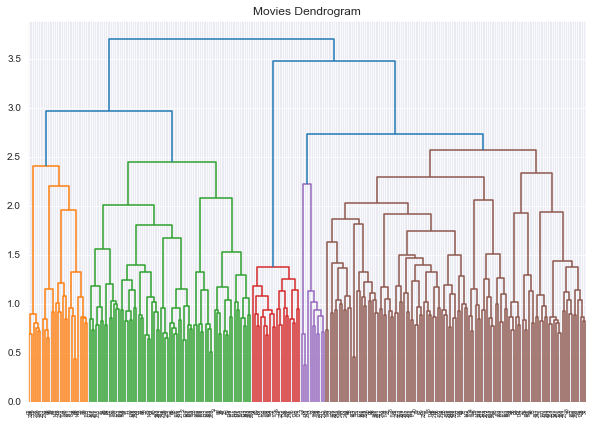

In [16]:
# Imports necessários
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Criando e plotando o dendrograma
plt.figure(figsize=(10, 7))
plt.title("Movies Dendrogram")
cluster_alg = shc.linkage(tfidf_matrix.toarray(), method='ward',)
dend = shc.dendrogram(cluster_alg)

O dendrograma separou os dados em 7 clusters, diferenciados pelas cores. No entanto, determinar esse número pode ser feito a partir da análise do dendrograma. Não existe um método específico para fazer isso. O que sabemos é que o tamanho das linhas verticais indicam a distância entre os clusters. Ou seja, quanto maior essa linha, mais separados estão os clusters analisados. 

Uma forma de verificar quantos clusters você pode separar os seus dados é traçando uma linha horizontal e verificar em quantos pontos essa linha toca as linhas verticais, essa quantidade de pontos é o número de cluster. Vamos analisar alguns gráficos.

Por enquanto, vamos usar a sugestão do dendograma e trabalhar com 7 clusters.

Para gerar o agrupamento final, vamos utilizar um cluster hierárquico no `scikit-learn` com os mesmo parâmetros passados na geração do dendrograma. Para isso, vamos usar o `AgglomerativeCluster`


In [17]:
# Imports Necessários
from sklearn.cluster import AgglomerativeClustering

# Criação do Cluster
agg_cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
clusters_agg = agg_cluster.fit_predict(tfidf_matrix.toarray())

In [18]:
# A variável clusters indica qual cluster cada texto foi atribuído. O código a seguir cria uma coluna 
# associando o rótulo do cluster a cada filme
dataframe_movie['cluster_agg'] = clusters_agg
dataframe_movie

,id,movie,year,text,cluster_km,cluster_agg
0,0111161,The Shawshank Redemption,1994,"In 1947, Andy Dufresne (\n\nTim Robbins\n\n), ...",2,2
1,0068646,The Godfather,1972,"In late summer 1945, guests are gathered for t...",1,4
2,0468569,The Dark Knight,2008,The movie begins with a gang of men with clown...,2,6
3,0071562,The Godfather Part II,1974,The Godfather Part II presents two parallel st...,1,2
4,0050083,12 Angry Men,1957,"In a New York City courthouse, an eighteen-yea...",3,2
...,...,...,...,...,...,...
245,0071411,Dersu Uzala,1975,Dersu Uzala is named after the character playe...,3,2
246,0103639,Aladdin,1992,A street peddler (Robin Williams) is guiding t...,3,2
247,1454029,The Help,2011,"In civil-rights era Jackson, Mississippi, 23-y...",1,1
248,0129167,The Iron Giant,1999,"In 1957, a large alien robot crashes from orbi...",3,2


## 5. Analisar os clusters gerados 

Como aplicamos técnicas distintas, a análise das informações referente a cada cluster será feita a partir das informações disponibilizadas por cada tipo de cluster. No caso do K-Means, a análise será feita dos atributos associados ao centróide de cada cluster. No caso do Cluster Hierárquico, vamos analisar as palavras mais frequentes dos filmes presentes em cada cluster. Vamos começar :) 

### Analisando o resultado do K-Means.

O primeiro passo é extrair quais foram os atributos que estão associados ao centróide de cada cluster. Isso pode ser feito a partir do atributo `cluster_centers_` que retorna o valor para cada um dos atributos na posição do centróide. 

In [19]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
order_centroids

array([[91, 62, 96, 71, 87, 19, 37, 12, 58, 47,  8, 69, 50, 13, 99, 18,
        92, 45, 46, 25, 27, 73, 49, 39, 67, 85, 76, 64, 21, 11, 86, 70,
        24,  9, 78, 40,  2, 26, 23, 88,  0,  1, 84, 98, 89,  3, 35, 36,
        33,  7,  4, 55, 95, 81, 38, 14, 83, 74, 93, 80, 32, 56, 51, 52,
        82, 63, 90, 59, 22, 43, 10, 15, 30, 77, 57, 54, 60, 34, 97, 53,
        42, 48, 20, 61, 68, 79, 65, 17, 66, 16, 72, 44, 94, 31, 28,  5,
        29,  6, 41, 75],
       [23, 22, 83, 64, 67, 41, 98, 63, 70, 13, 40, 99, 87, 28, 57, 86,
        29, 55, 27, 11,  4, 49, 95, 93, 85,  2, 24, 97, 91, 76, 52, 37,
        77, 92,  9, 53, 39, 43,  7,  0, 58, 90, 84, 69, 45, 96, 73, 68,
         3, 33, 66, 61,  1, 10, 54, 59, 26, 12, 89, 75,  6, 56, 18, 32,
        21, 47, 50, 82, 94, 30,  8, 46, 81, 14, 16, 25, 51, 79, 88, 62,
        34, 78, 48,  5, 72, 31, 17, 15, 60, 19, 36, 38, 71, 20, 80, 74,
        65, 35, 42, 44],
       [87,  6, 80, 62,  1, 78, 33,  2, 63, 75, 27, 17, 88, 30, 45, 86,
        15, 89

Cada índice desta lista é uma palavra que corresponde a um atributo da matriz utilizada para treinar o modelo não-supervisionado. Para descobrir a palavra, basta ver a lista de palavras geradas pelo método de vetorização. 

In [21]:
# Criação de uma veriável com a lista de palavras que representa as colunas da matriz.
terms = tfidf_vectorizer.get_feature_names_out()

In [22]:
terms

array(['arrives', 'asks', 'away', 'begins', 'boy', 'calls', 'car',
       'children', 'city', 'come', 'comes', 'day', 'dead', 'death',
       'does', 'doesn', 'don', 'door', 'end', 'escape', 'explains',
       'face', 'family', 'father', 'fight', 'film', 'finally', 'finds',
       'friend', 'friends', 'gets', 'girl', 'gives', 'goes', 'going',
       'gun', 'hand', 'having', 'head', 'help', 'home', 'house', 'inside',
       'job', 'john', 'just', 'kill', 'killed', 'know', 'later', 'leave',
       'leaves', 'left', 'like', 'little', 'lives', 'long', 'love',
       'make', 'makes', 'meet', 'meets', 'men', 'money', 'mother', 'mr',
       'named', 'new', 'nick', 'night', 'old', 'orders', 'outside',
       'people', 'place', 'police', 'return', 'returns', 'room', 'runs',
       'says', 'sees', 'small', 'son', 'soon', 'story', 'takes', 'tells',
       'town', 'tries', 'wants', 'war', 'way', 'wife', 'woman', 'work',
       'world', 'year', 'years', 'young'], dtype=object)

Por fim, vamos ver quais palavras que melhor caracterizam cada um dos clusters criados. 

In [23]:
centroids = []
# 5 foi o número de clusters que usamos para treinar o modelo do K-Means
for i in range(5): 
  list_id = order_centroids[i]
  list_terms = [terms[id] for id in list_id[:10]]
  centroids.append({'cluster': i, 'words': ', '.join(list_terms)})

df_centroids = pd.DataFrame(centroids)
df_centroids

,cluster,words
0,0,"war, men, world, orders, tells, escape, having..."
1,1,"father, family, son, mother, new, house, years..."
2,2,"tells, car, says, men, asks, room, goes, away,..."
3,3,"new, boy, city, home, love, day, young, film, ..."
4,4,"police, wife, mr, john, tells, death, nick, wo..."


Vamos selecionar alguns filmes de cada um do cluster. 

In [25]:
for n in range(5):
  print("Cluster %i: %s" % (n, list(df_centroids[df_centroids['cluster'] == n]['words'][:5])))
  data_selected = dataframe_movie[dataframe_movie['cluster_km'] == n]
  for index, row in data_selected.head(10).iterrows():
    print("\tFilme: %s" % row['movie'])
  print()

Cluster 0: ['war, men, world, orders, tells, escape, having, dead, make, killed']
	Filme: Schindler's List
	Filme: The Lord of the Rings: The Return of the King
	Filme: The Good, the Bad and the Ugly
	Filme: The Lord of the Rings: The Two Towers
	Filme: Saving Private Ryan
	Filme: Casablanca
	Filme: Grave of the Fireflies
	Filme: Apocalypse Now
	Filme: Paths of Glory
	Filme: The Great Dictator

Cluster 1: ['father, family, son, mother, new, house, years, money, old, death']
	Filme: The Godfather
	Filme: The Godfather Part II
	Filme: Goodfellas
	Filme: Life Is Beautiful
	Filme: Interstellar
	Filme: The Pianist
	Filme: Parasite
	Filme: Léon: The Professional
	Filme: Gladiator
	Filme: Harakiri

Cluster 2: ['tells, car, says, men, asks, room, goes, away, money, police']
	Filme: The Shawshank Redemption
	Filme: The Dark Knight
	Filme: Pulp Fiction
	Filme: Fight Club
	Filme: Inception
	Filme: The Matrix
	Filme: Back to the Future
	Filme: Spirited Away
	Filme: Psycho
	Filme: The Lion King

Cl

### Analisando o resultado do Cluster Hierárquico.

No caso do cluster hierárquico, vamos pegar as informações dirertamente do dataframe já que esse método não possui um centróide para analisar. Vamos pegar os termos mais relevantes de acordo com o `TfidfVectorizer`. 


In [27]:
import collections

top_words_by_movie = []

for row in tfidf_matrix.toarray():
  a = row
  b = tfidf_vectorizer.get_feature_names_out()

  dict_words = dict(zip(b, a))
  sorted_dict = sorted(dict_words.items(), key=lambda x: x[1], reverse=True)
  
  top_words_by_movie.append({'words': [w[0] for w in sorted_dict[:5]]})
  count += 1

In [28]:
# 7 foi o número de clusters usados para treinar o cluster hierárquico
for i in range(7):
  all_cluster_i = dataframe_movie[dataframe_movie['cluster_agg']==i]
  all_movies_index = list(all_cluster_i.index)
  cluster_words = [w for m in all_movies_index for w in top_words_by_movie[m]['words']]
  word_count = sorted(dict(collections.Counter(cluster_words)).items(), key=lambda x: x[1], reverse=True)
  print("Cluster %i: %s" % (i, [word[0] for word in word_count[:5]]))
  for index, row in all_cluster_i.head(10).iterrows():
    print("\tFilme: %s" % row['movie'])
  print()


Cluster 0: ['police', 'wife', 'mr', 'john', 'tells']
	Filme: Se7en
	Filme: It's a Wonderful Life
	Filme: The Green Mile
	Filme: Terminator 2: Judgment Day
	Filme: The Departed
	Filme: The Usual Suspects
	Filme: The Intouchables
	Filme: Rear Window
	Filme: Memento
	Filme: Witness for the Prosecution

Cluster 1: ['father', 'son', 'mother', 'family', 'old']
	Filme: The Lord of the Rings: The Fellowship of the Ring
	Filme: Life Is Beautiful
	Filme: Interstellar
	Filme: Star Wars: Episode IV - A New Hope
	Filme: Psycho
	Filme: Léon: The Professional
	Filme: The Lion King
	Filme: Gladiator
	Filme: Whiplash
	Filme: Amadeus

Cluster 2: ['boy', 'new', 'love', 'children', 'city']
	Filme: The Shawshank Redemption
	Filme: The Godfather Part II
	Filme: 12 Angry Men
	Filme: The Lord of the Rings: The Return of the King
	Filme: Forrest Gump
	Filme: Star Wars: Episode V - The Empire Strikes Back
	Filme: Goodfellas
	Filme: One Flew Over the Cuckoo's Nest
	Filme: The Silence of the Lambs
	Filme: City of

Com isso finalizamos essa atividade. Observe que temos informações suficientes para analisar o que cada cluster quer contar :) Podemos melhorar as informações de cada cluster mexendo um pouco mais no pré-processamento do texto, mas isso não será feito agora, mas fiquem à vontade para fazer :) 

Agora é a sua vez de colocar esse conhecimento em prática. Tenho uma atividade na próxima seção ;)